# Imports

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
sns.set(rc={'figure.figsize':(25,10)})
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import holidays
from sklearn.metrics import mean_absolute_error

# Import prepared DF

In [321]:
# Load prepared dataset
df_days = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_prepared_df_272.csv")

import numpy as np

df_days.rename(columns={'holidays': 'holiday_indicator'}, inplace=True)

print(df_days.head())

         date  nb_cars  nb_cars_cxl  nb_bookings  nb_bookings_cxl  \
0  2021-06-01       12            2            5                1   
1  2021-06-02       15            2            3                0   
2  2021-06-03       13            0            4                0   
3  2021-06-04        9            0            2                0   
4  2021-06-05        7            0            2                0   

   hourly rate  WE package  1 week package  1 month package  other package  \
0            3           0               6                3              0   
1            6           0               6                3              0   
2            5           0               6                2              0   
3            2           0               5                2              0   
4            1           2               2                2              0   

   ...  12H à 15H  0H à 6H  18H à 24H  +24h  06:00 24:00  00:30 06:00  \
0  ...          2        0          1    12

# Prophet nb of cars

## Just the nb of cars as y

In [322]:
df_prophet_cars = df_days[['date', 'nb_cars']]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})
df_prophet_cars.head()


,ds,y
0,2021-06-01,12
1,2021-06-02,15
2,2021-06-03,13
3,2021-06-04,9
4,2021-06-05,7


In [323]:
# Define the split percentages
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

# Calculate the number of rows for each set
total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

# Split the data into train, test, and validation sets
train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]
validation_set = df_prophet_cars[train_rows + test_rows:]

print("train_rows:", train_rows)
print("test_rows:", test_rows)
print("validation_rows:", validation_rows)
print()

train_rows: 675
test_rows: 37
validation_rows: 38



In [324]:
model = Prophet()
model.fit(df_prophet_cars)

# Create future dates for the test and validation periods
future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

# Predict on the test and validation sets
forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)


21:50:26 - cmdstanpy - INFO - Chain [1] start processing
21:50:26 - cmdstanpy - INFO - Chain [1] done processing


In [325]:
# Calculate RMSE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
print("RMSE for the test set:", rmse_test)

RMSE for the test set: 33.26501694682911


In [326]:
mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

MAPE for the test set: 29.936060523580043


In [327]:
# Calculate MAE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
mae_test = mean_absolute_error(y_true_test, y_pred_test)
print("MAE for the test set:", mae_test)

MAE for the test set: 25.559959148142084


## Forecast nb of cars with french holidays (from holidays package)

In [328]:
df_prophet_cars = df_days.drop(['nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl'], axis=1)
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})

# Add the 'holiday' column
fr_holidays = holidays.France()
df_prophet_cars['holiday'] = df_prophet_cars['ds'].apply(lambda x: x in fr_holidays)
df_prophet_cars['ds'] = pd.to_datetime(df_prophet_cars['ds'])

# Create a separate DataFrame for holidays
holidays_df = df_prophet_cars[df_prophet_cars['holiday']]
holidays_df['holiday'] = 'Holiday'

model = Prophet(holidays=holidays_df)
model.fit(df_prophet_cars)

# Create future dates (365 days)
future = model.make_future_dataframe(periods=14)
future.tail()

# Predict
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Calculate train, test, validation sets and evaluate accuracy
train_percentage = 0.9
test_percentage = 0.05
validation_percentage = 0.05

total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]
validation_set = df_prophet_cars[train_rows + test_rows:]

model = Prophet(holidays=holidays_df)
model.fit(train_set)

future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))





/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_57992/3227057497.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df['holiday'] = 'Holiday'
/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:50:26 - cmdstanpy - INFO - Chain [1] start processing
21:50:26 - cmdstanpy - INFO - Chain [1] done processing


/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:50:27 - cmdstanpy - INFO - Chain [1] start processing
21:50:27 - cmdstanpy - INFO - Chain [1] done processing


In [329]:
print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

# Calculate MAE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
mae_test = mean_absolute_error(y_true_test, y_pred_test)
print("MAE for the test set:", mae_test)

RMSE for the test set: 32.79605593260834
MAPE for the test set: 30.079966922708767
MAE for the test set: 25.902281903262065


In [330]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Holiday,Holiday_lower,Holiday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-01,24.606320,-10.396200,47.711359,24.606320,24.606320,0.0,0.0,0.0,-6.355084,...,-5.667084,-5.667084,-5.667084,-0.688001,-0.688001,-0.688001,0.0,0.0,0.0,18.251236
1,2021-06-02,24.663515,-2.094852,54.869969,24.663515,24.663515,0.0,0.0,0.0,1.404298,...,2.145061,2.145061,2.145061,-0.740764,-0.740764,-0.740764,0.0,0.0,0.0,26.067812
2,2021-06-03,24.720710,0.350323,55.373190,24.720710,24.720710,0.0,0.0,0.0,2.572966,...,3.427148,3.427148,3.427148,-0.854182,-0.854182,-0.854182,0.0,0.0,0.0,27.293676
3,2021-06-04,24.777905,-6.099161,51.671861,24.777905,24.777905,0.0,0.0,0.0,-1.979887,...,-0.958179,-0.958179,-0.958179,-1.021708,-1.021708,-1.021708,0.0,0.0,0.0,22.798017
4,2021-06-05,24.835100,-1.435786,57.081937,24.835100,24.835100,0.0,0.0,0.0,4.473251,...,5.708751,5.708751,5.708751,-1.235501,-1.235501,-1.235501,0.0,0.0,0.0,29.308350


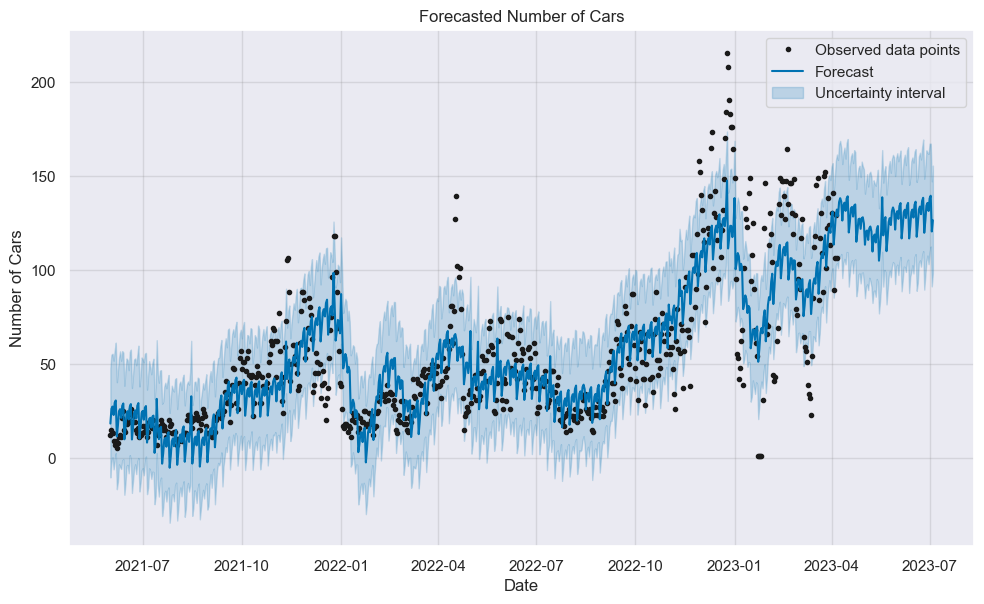

In [331]:
# Plot the graph
fig1 = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Number of Cars')
plt.title('Forecasted Number of Cars')

# Add legend
plt.legend()

plt.show()

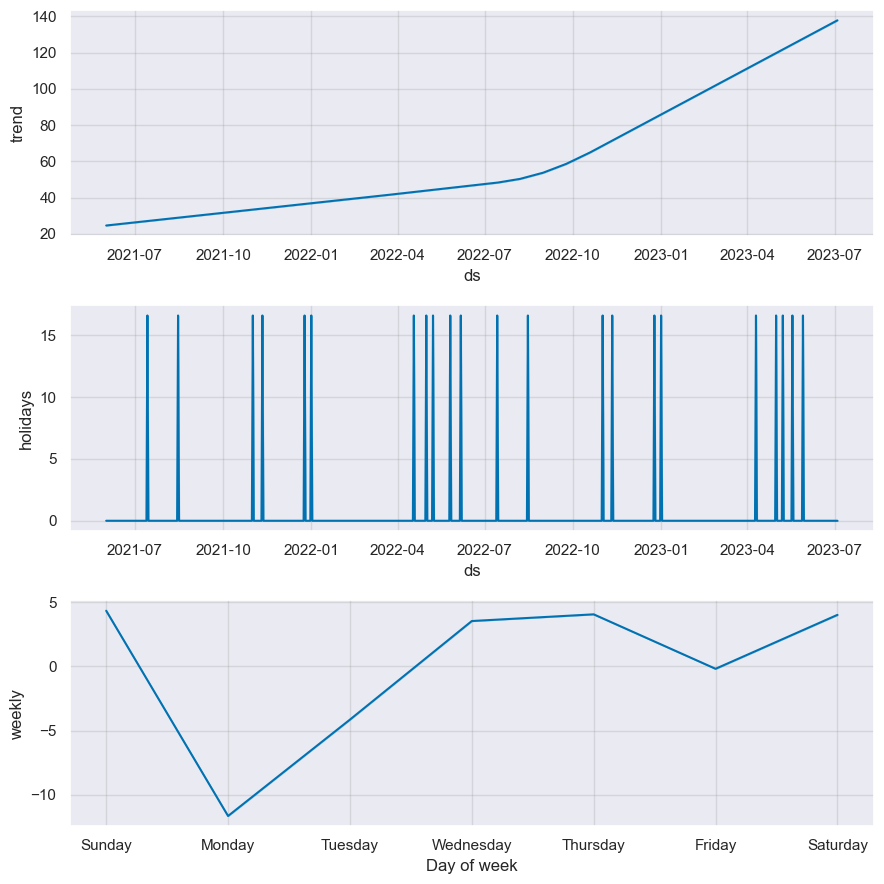

In [332]:
# Explain seasonality
fig2 = model.plot_components(forecast)


# Prophet with strikes, vacation & holidays

In [342]:
# Load prepared dataset
df_days = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_prepared_df_272.csv")

df_days.rename(columns={'holidays': 'holiday_indicator'}, inplace=True)

df_prophet_cars = df_days[['date', 'nb_cars','holiday_indicator'
                           #, 'vacation', 'strike'
                           ]]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})
df_prophet_cars['holiday_indicator'].fillna(method='ffill', inplace=True)

print(df_prophet_cars.head())

#df_prophet_cars['strike'] = 0  # Replace 0 with your strike data
#df_prophet_cars['vacations'] = 0  # Replace 0 with your vacations data
df_prophet_cars['holiday_indicator'] = 0  # Replace 0 with your holidays data


fr_holidays = holidays.France()
df_prophet_cars['holiday_indicator'] = df_prophet_cars['ds'].apply(lambda x: x in fr_holidays)
df_prophet_cars['ds'] = pd.to_datetime(df_prophet_cars['ds'])

#holidays_df = df_prophet_cars[df_prophet_cars['holiday_indicator']]
#holidays_df['holiday_indicator'] = 'holiday_indicator'


model = Prophet()
#model.add_regressor('strike')
#model.add_regressor('vacations')
model.add_regressor('holiday_indicator')
model.fit(df_prophet_cars)

future_test = model.make_future_dataframe(periods=365)
#future_test['strike'] = 0  # Replace 0 with your strike data
#future_test['vacations'] = 0  # Replace 0 with your vacations data
future_test['holiday_indicator'] = 0  # Replace 0 with your holidays data

forecast_test = model.predict(future_test)
forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

# Calculate MAE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
mae_test = mean_absolute_error(y_true_test, y_pred_test)
print("MAE for the test set:", mae_test)

21:51:25 - cmdstanpy - INFO - Chain [1] start processing
21:51:26 - cmdstanpy - INFO - Chain [1] done processing


           ds   y  holiday_indicator
0  2021-06-01  12                  0
1  2021-06-02  15                  0
2  2021-06-03  13                  0
3  2021-06-04   9                  0
4  2021-06-05   7                  0
MAPE for the test set: 109.4480820782324
MAE for the test set: 106.77824700410966


In [343]:
forecast_test

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-01,24.606320,-9.873801,48.372602,24.606320,24.606320,-6.355084,-6.355084,-6.355084,0.0,...,-5.667084,-5.667084,-5.667084,-0.688001,-0.688001,-0.688001,0.0,0.0,0.0,18.251236
1,2021-06-02,24.663515,-1.115004,55.586577,24.663515,24.663515,1.404298,1.404298,1.404298,0.0,...,2.145061,2.145061,2.145061,-0.740764,-0.740764,-0.740764,0.0,0.0,0.0,26.067812
2,2021-06-03,24.720710,1.133249,56.945190,24.720710,24.720710,2.572966,2.572966,2.572966,0.0,...,3.427148,3.427148,3.427148,-0.854182,-0.854182,-0.854182,0.0,0.0,0.0,27.293676
3,2021-06-04,24.777905,-5.758088,51.239182,24.777905,24.777905,-1.979887,-1.979887,-1.979887,0.0,...,-0.958179,-0.958179,-0.958179,-1.021708,-1.021708,-1.021708,0.0,0.0,0.0,22.798017
4,2021-06-05,24.835100,-0.234486,56.743113,24.835100,24.835100,4.473251,4.473251,4.473251,0.0,...,5.708751,5.708751,5.708751,-1.235501,-1.235501,-1.235501,0.0,0.0,0.0,29.308350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2024-06-15,235.693568,207.201077,268.298006,225.285127,247.001482,1.795257,1.795257,1.795257,0.0,...,5.708751,5.708751,5.708751,-3.913495,-3.913495,-3.913495,0.0,0.0,0.0,237.488825
1111,2024-06-16,235.975830,206.105759,268.044505,225.521168,247.293408,3.076764,3.076764,3.076764,0.0,...,7.120756,7.120756,7.120756,-4.043992,-4.043992,-4.043992,0.0,0.0,0.0,239.052593
1112,2024-06-17,236.258091,189.292761,251.945209,225.767697,247.598699,-15.912287,-15.912287,-15.912287,0.0,...,-11.776454,-11.776454,-11.776454,-4.135833,-4.135833,-4.135833,0.0,0.0,0.0,220.345804
1113,2024-06-18,236.540353,195.175078,257.708180,226.019163,247.951697,-9.857911,-9.857911,-9.857911,0.0,...,-5.667084,-5.667084,-5.667084,-4.190828,-4.190828,-4.190828,0.0,0.0,0.0,226.682441


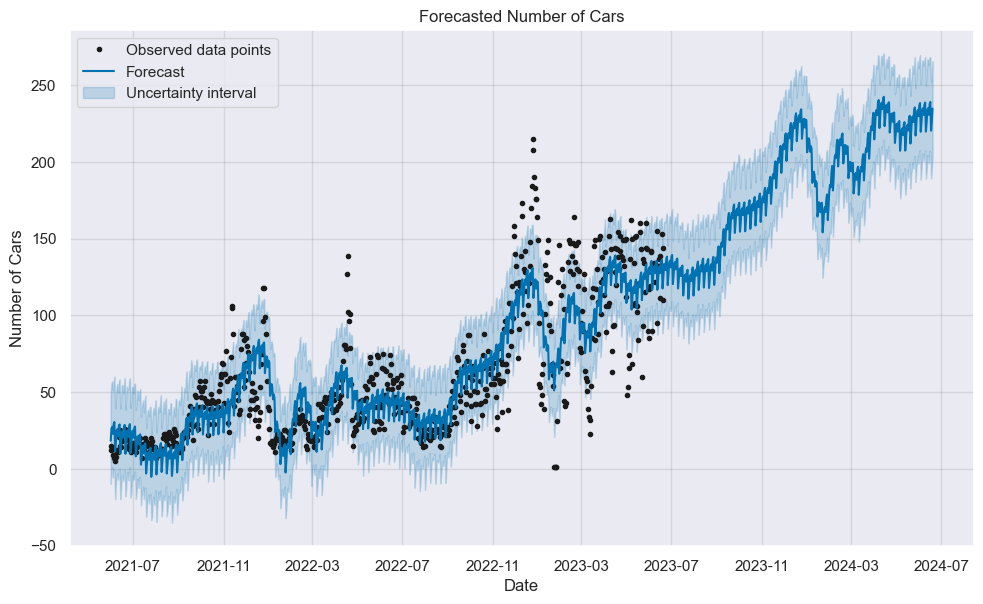

In [344]:
# Plot the graph
fig1 = model.plot(forecast_test)
plt.xlabel('Date')
plt.ylabel('Number of Cars')
plt.title('Forecasted Number of Cars')

# Add legend
plt.legend()

plt.show()

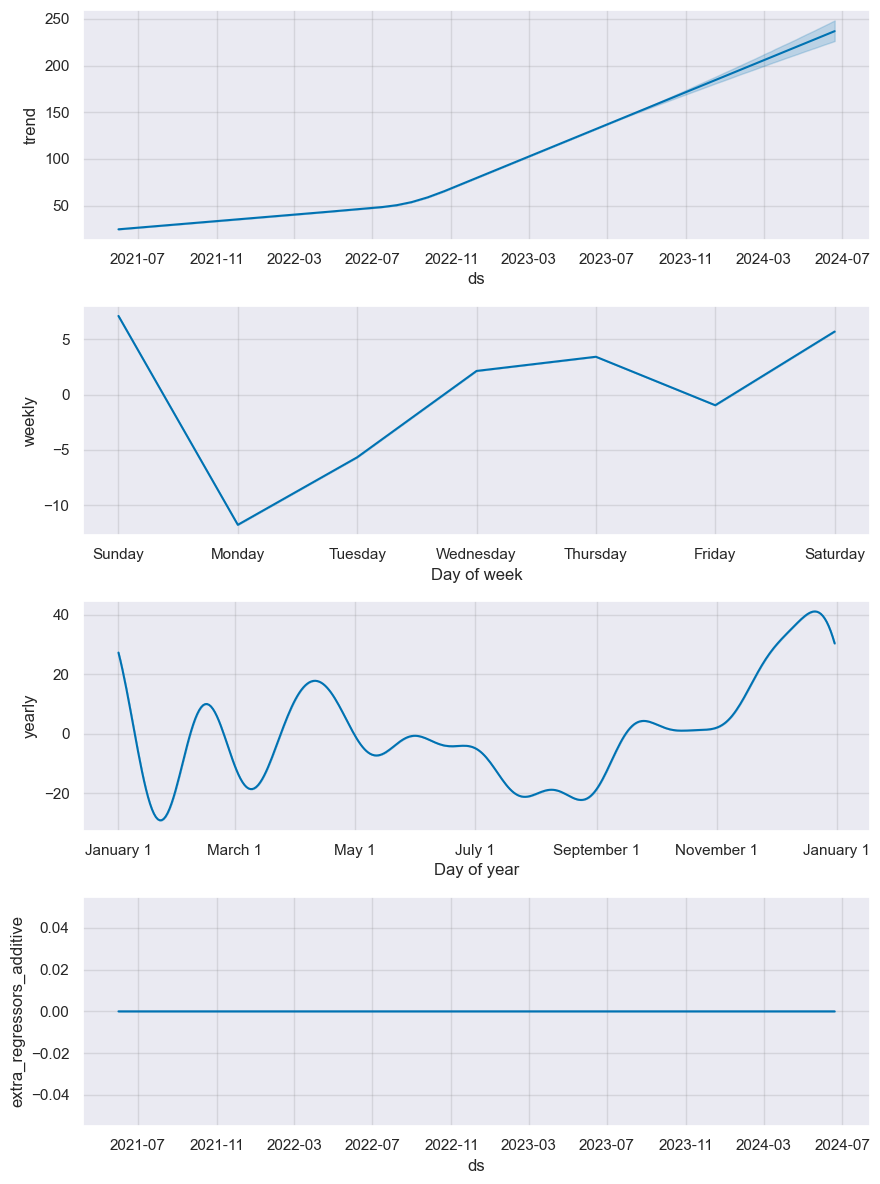

In [345]:
# Explain seasonality
fig2 = model.plot_components(forecast_test)

# Prophet with 1 week package

In [346]:
# Load prepared dataset
df_days = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_prepared_df_5435.csv")


df_prophet_cars = df_days[['date', 'nb_bookings','booking_fees']]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_bookings': 'y'})

print(df_prophet_cars.head())

df_prophet_cars['booking_fees'] = 0  # Replace 0 with your turnover data
#df_prophet_cars['booking_fees'] = 0  # Replace 0 with your booking_fees data

#df_prophet_cars['holiday_indicator'] = df_prophet_cars['ds'].apply(lambda x: x in fr_holidays)
df_prophet_cars['ds'] = pd.to_datetime(df_prophet_cars['ds'])

model_2 = Prophet()
model_2.add_regressor('booking_fees')
#model.add_regressor('booking_fees')
model_2.fit(df_prophet_cars)

future_2 = model_2.make_future_dataframe(periods=365)
future_2['booking_fees'] = 0  # Replace 0 with your strike data
#future['booking_fees'] = 0  # Replace 0 with your vacations data


forecast_2 = model_2.predict(future_2)
forecast_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

y_true_test_2 = test_set['y']
y_pred_test_2 = forecast_2['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test_2))

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test_2) * 100
print("MAPE for the test set:", mape_test)

# Calculate MAE for the test set
y_true_test_2 = test_set['y']
y_pred_test_2 = forecast_2['yhat'].tail(len(test_set))
mae_test = mean_absolute_error(y_true_test_2, y_pred_test_2)
print("MAE for the test set:", mae_test)

21:51:27 - cmdstanpy - INFO - Chain [1] start processing
21:51:27 - cmdstanpy - INFO - Chain [1] done processing


           ds   y  booking_fees
0  2021-06-01   6           0.0
1  2021-06-02   4           0.0
2  2021-06-03  11           0.0
3  2021-06-04  18           0.0
4  2021-06-05   7           0.0
MAPE for the test set: 72.21165574127033
MAE for the test set: 90.67273330986393


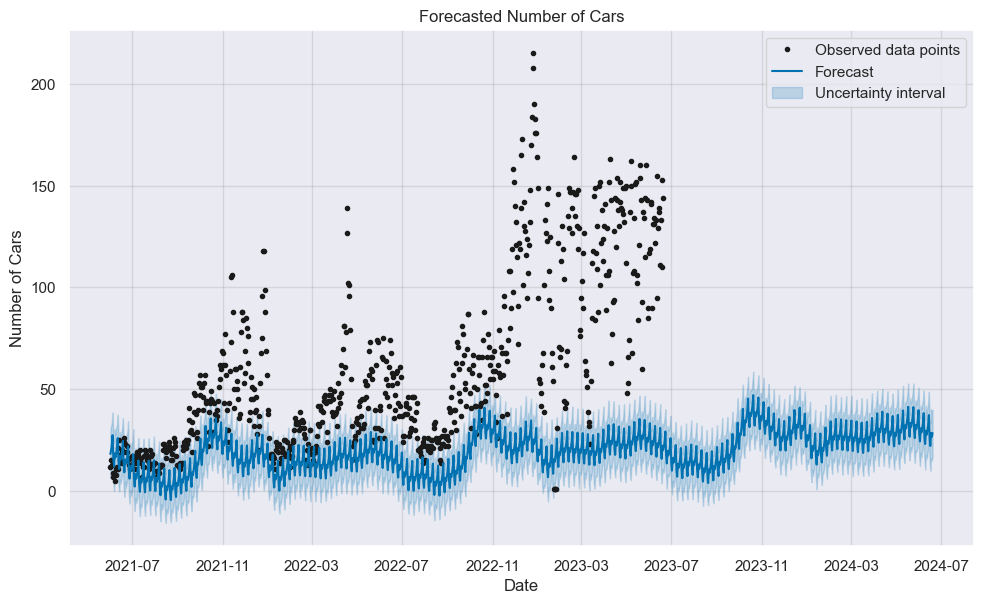

In [347]:
# Plot the graph
fig1 = model.plot(forecast_2)
plt.xlabel('Date')
plt.ylabel('Number of Cars')
plt.title('Forecasted Number of Cars')

# Add legend
plt.legend()

plt.show()

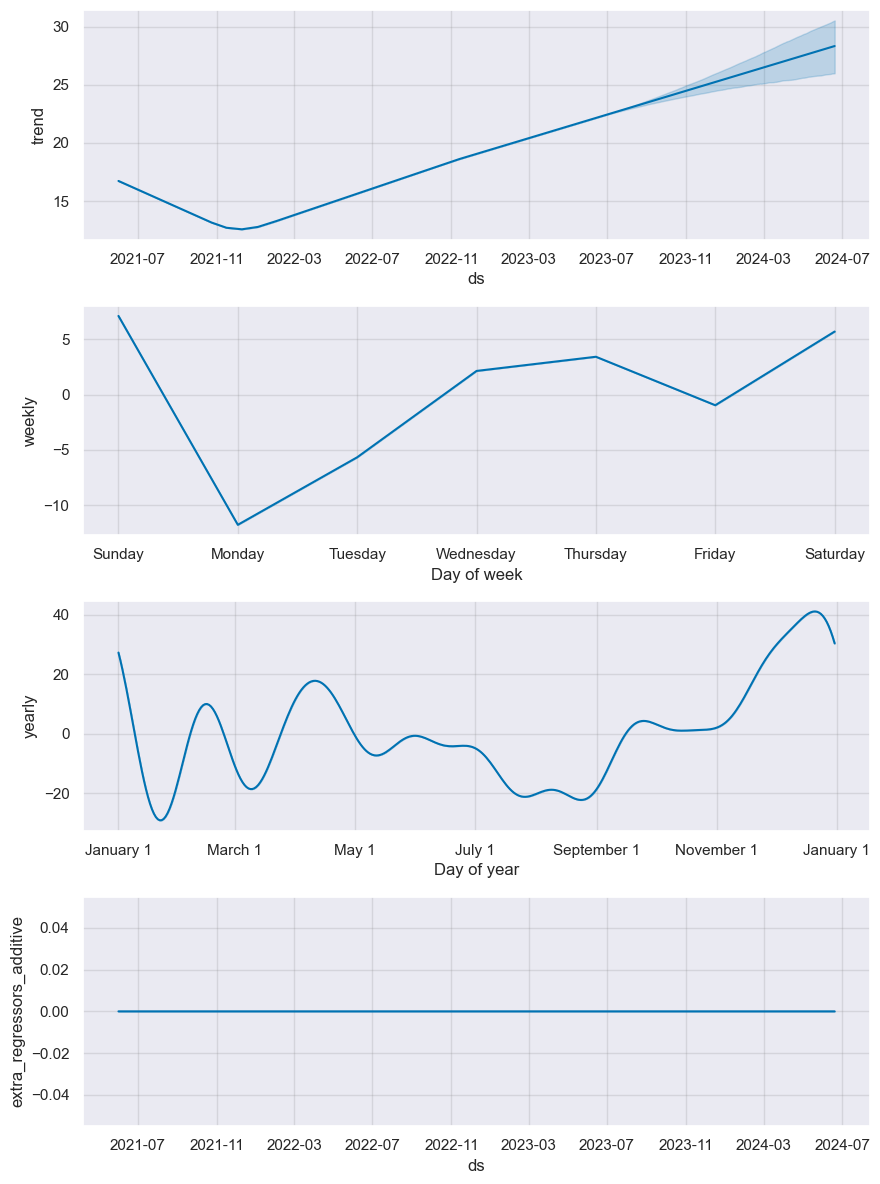

In [348]:
# Explain seasonality
fig2 = model.plot_components(forecast_2)

In [349]:
forecast_2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,booking_fees,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-01,16.728707,6.447093,29.724663,16.728707,16.728707,1.466635,1.466635,1.466635,0.0,...,-1.806679,-1.806679,-1.806679,3.273314,3.273314,3.273314,0.0,0.0,0.0,18.195342
1,2021-06-02,16.703939,8.682805,32.138515,16.703939,16.703939,3.334584,3.334584,3.334584,0.0,...,0.313928,0.313928,0.313928,3.020657,3.020657,3.020657,0.0,0.0,0.0,20.038523
2,2021-06-03,16.679170,11.211062,33.554901,16.679170,16.679170,5.744114,5.744114,5.744114,0.0,...,2.965573,2.965573,2.965573,2.778541,2.778541,2.778541,0.0,0.0,0.0,22.423284
3,2021-06-04,16.654402,16.046098,38.567998,16.654402,16.654402,10.755415,10.755415,10.755415,0.0,...,8.205959,8.205959,8.205959,2.549456,2.549456,2.549456,0.0,0.0,0.0,27.409817
4,2021-06-05,16.629634,4.364334,26.791464,16.629634,16.629634,-0.639335,-0.639335,-0.639335,0.0,...,-2.974353,-2.974353,-2.974353,2.335018,2.335018,2.335018,0.0,0.0,0.0,15.990299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2024-06-15,28.279490,14.745755,36.590239,25.981014,30.442972,-2.287715,-2.287715,-2.287715,0.0,...,-2.974353,-2.974353,-2.974353,0.686638,0.686638,0.686638,0.0,0.0,0.0,25.991775
1111,2024-06-16,28.296162,9.992003,33.202893,25.987919,30.474368,-6.168082,-6.168082,-6.168082,0.0,...,-6.668672,-6.668672,-6.668672,0.500590,0.500590,0.500590,0.0,0.0,0.0,22.128080
1112,2024-06-17,28.312835,15.992235,40.258535,25.988887,30.500065,0.256305,0.256305,0.256305,0.0,...,-0.035755,-0.035755,-0.035755,0.292060,0.292060,0.292060,0.0,0.0,0.0,28.569139
1113,2024-06-18,28.329507,14.997831,39.476011,25.994988,30.525763,-1.749508,-1.749508,-1.749508,0.0,...,-1.806679,-1.806679,-1.806679,0.057171,0.057171,0.057171,0.0,0.0,0.0,26.579999


In [350]:
# Load prepared dataset
df_days = pd.read_csv("../prepared_data/01_06_2021_to_20_06_2023_prepared_df_5435.csv")


df_prophet_cars = df_days[['date', 'nb_cars','nb_cars_cxl', 'booking_fees']]
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})

print(df_prophet_cars.head())

df_prophet_cars['turnover'] = 0  # Replace 0 with your turnover data
df_prophet_cars['booking_fees'] = 0  # Replace 0 with your booking_fees data

df_prophet_cars['holiday_indicator'] = df_prophet_cars['ds'].apply(lambda x: x in fr_holidays)
df_prophet_cars['ds'] = pd.to_datetime(df_prophet_cars['ds'])

model = Prophet()
model.add_regressor('turnover')
model.add_regressor('booking_fees')
model.fit(df_prophet_cars)

future = model.make_future_dataframe(periods=365)
future['turnover'] = 0  # Replace 0 with your strike data
future['booking_fees'] = 0  # Replace 0 with your vacations data


forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

# Calculate MAE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
mae_test = mean_absolute_error(y_true_test, y_pred_test)
print("MAE for the test set:", mae_test)

21:51:29 - cmdstanpy - INFO - Chain [1] start processing


21:51:29 - cmdstanpy - INFO - Chain [1] done processing


           ds   y  nb_cars_cxl  booking_fees
0  2021-06-01  31            2           0.0
1  2021-06-02  26            2           0.0
2  2021-06-03  28            2           0.0
3  2021-06-04  29            2           0.0
4  2021-06-05  42            2           0.0
MAPE for the test set: 109.4480820782324
MAE for the test set: 106.77824700410966
